## Ecological/host phenotype: data analysis, processing, and visualization

#### 1. Read the train and test datasets

In [1]:
import pandas as pd
import numpy as np
import torch
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Add the parent directory to sys.path (to import util function)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from utils.utils import read_host_data, pca_run_and_plot, tsne_plot, plot_accuracy_metric

TAX_LEVEL = "family"
RANDOM_SEED = 42
OUTPUT_DIRECTORY = f"../data_host/plots_{TAX_LEVEL}_TAX_LEVEL"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Read train data
data_filename_train = f"../data_host/input_data/train_data_{TAX_LEVEL}_TAX_LEVEL"
y_filename_train = f"../data_host/input_data/train_annot_{TAX_LEVEL}_TAX_LEVEL"
taxa_names_filename_train = f"../data_host/input_data/train_taxa_names_{TAX_LEVEL}_TAX_LEVEL"
X_val_train, y_label_train, X_column_names, taxa_group_names_train = read_host_data(data_filename_train, y_filename_train, taxa_names_filename_train, DEVICE)

# Read test data
data_filename_test = f"../data_host/input_data/test_data_{TAX_LEVEL}_TAX_LEVEL"
y_filename_test = f"../data_host/input_data/test_annot_{TAX_LEVEL}_TAX_LEVEL"
taxa_names_filename_test = f"../data_host/input_data/test_taxa_names_{TAX_LEVEL}_TAX_LEVEL"
X_val_test, y_label_test, X_column_names, taxa_group_names_test = read_host_data(data_filename_test, y_filename_test, taxa_names_filename_test, DEVICE)

In [2]:
# Find indices where the value is zero
zero_indices = (y_label_train == 0).nonzero(as_tuple=True)[0]
N = 4000  # or however many you want
selected_indices = zero_indices[torch.randperm(len(zero_indices))[:N]]
mask = torch.ones_like(y_label_train, dtype=torch.bool)
mask[selected_indices] = False
y_label_train = y_label_train[mask]
X_val_train = X_val_train[mask]
taxa_group_names_train = [item for i, item in enumerate(taxa_group_names_train) if i not in selected_indices.tolist()]
#taxa_names_filename_train = [taxa_names_filename_train[i] for i in selected_indices.tolist()]


# Find indices where the value is zero
zero_indices = (y_label_test == 0).nonzero(as_tuple=True)[0]
N = 800  # or however many you want
selected_indices = zero_indices[torch.randperm(len(zero_indices))[:N]]
mask = torch.ones_like(y_label_test, dtype=torch.bool)
mask[selected_indices] = False
y_label_test = y_label_test[mask]
X_val_test = X_val_test[mask]
taxa_group_names_test = [taxa_group_names_test[i] for i in selected_indices.tolist()]

In [3]:
num_host_train = float(sum(y_label_train.cpu()))
num_ecological_train = float(len(y_label_train.cpu()) - num_host_train)
print(f"Number of Host in train = {num_host_train}, which is {round(100*num_host_train/(num_host_train+num_ecological_train),2)} %")
print(f"Number of Ecological = {num_ecological_train}, which is {round(100*num_ecological_train/(num_host_train+num_ecological_train),2)} %\n")

num_host_test = float(sum(y_label_test.cpu()))
num_ecological_test = float(len(y_label_test.cpu()) - num_host_test)
print(f"Number of Host in test = {num_host_test}, which is {round(100*num_host_test/(num_host_test+num_ecological_test),2)} %")
print(f"Number of Ecological = {num_ecological_test}, which is {round(100*num_ecological_test/(num_host_test+num_ecological_test),2)} %")

Number of Host in train = 421.0, which is 36.11 %
Number of Ecological = 745.0, which is 63.89 %

Number of Host in test = 121.0, which is 23.96 %
Number of Ecological = 384.0, which is 76.04 %


#### 2. PCA and tSNE projections

In [4]:
if not os.path.exists(OUTPUT_DIRECTORY):
    os.makedirs(OUTPUT_DIRECTORY)

Data after PCA reduction: (1166, 20)
Shape of the projected data = (1166, 2)


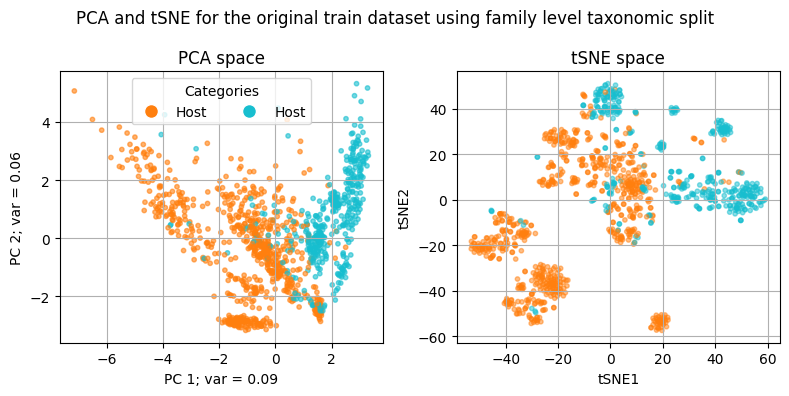

In [5]:
plt.figure(figsize=(8, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 20
colors = ListedColormap(["tab:orange", "tab:cyan"])
category_names = ["Host" if yi == 0 else "Ecological" for yi in y_label_train]
pca_run_and_plot(X_val_train.cpu(), n_compon, y_label_train.cpu(), category_names, colors,legend_flag=True);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_val_train.cpu(), 30, 100, RANDOM_SEED, y_label_train.cpu(), colors);

# Display the plots
plt.suptitle(f"PCA and tSNE for the original train dataset using {TAX_LEVEL} level taxonomic split")
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tse_orig_phenot.pdf", format="pdf")
plt.show()

Data after PCA reduction: (1166, 20)
Shape of the projected data = (1166, 2)


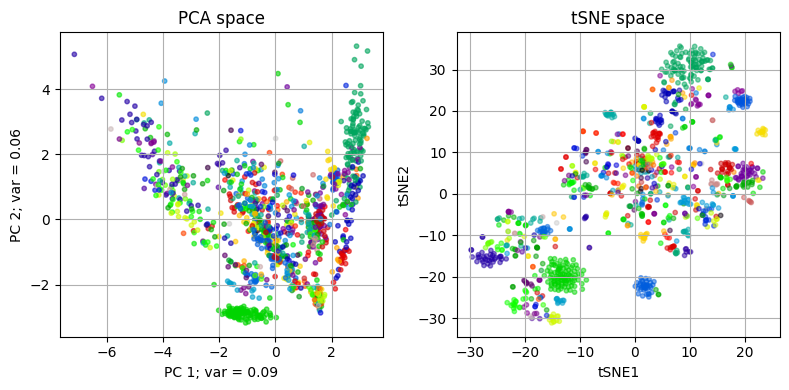

In [6]:
plt.figure(figsize=(8, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 20
category_names = ["Host" if yi == 0 else "Ecological" for yi in y_label_train]
pca_run_and_plot(X_val_train.cpu(), n_compon, taxa_group_names_train, taxa_group_names_train, None,legend_flag=False);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_val_train.cpu(), 70, 100, RANDOM_SEED, taxa_group_names_train, None);

# Display the plots
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tse_orig_phylogen.pdf", format="pdf")
plt.show()

#### 3. XGBoost training and feature selection

First, find baseline (for all GOGs) test and cross-validation accuracy measures.

In [7]:
from feature_selection.feature_selection_utils import xgboost_train_accur, xgboost_accur_select_features

cv_accuracy_scores, test_accuracy_scores = xgboost_train_accur(X_val_train, y_label_train, X_val_test, y_label_test, DEVICE)
print(f"XGBoost baseline test accuracy (all features) = {test_accuracy_scores}")
print(f"XGBoost cv_accuracy (all features) = {test_accuracy_scores}")

C:\Users\kolda\AppData\Local\Programs\Python\Python312\Lib\site-packages\cupy\_environment.py:217: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


XGBoost baseline test accuracy (all features) = {'accuracy': 0.9504950495049505, 'precision': 0.875, 'recall': 0.9256198347107438, 'f1': 0.8995983935742972, 'roc_auc': 0.9841813016528925}
XGBoost cv_accuracy (all features) = {'accuracy': 0.9504950495049505, 'precision': 0.875, 'recall': 0.9256198347107438, 'f1': 0.8995983935742972, 'roc_auc': 0.9841813016528925}


In [8]:
X_train_np = np.array(X_val_train.cpu())
X_train_transposed = X_train_np.T

#### 3.1 Feature selection with Mutual Information

In [9]:
from feature_selection.feature_selection_utils import mutual_info_features

sorted_cog_idx_by_mi, sorted_mi, sorted_names = mutual_info_features(X_val_train.cpu(), y_label_train.cpu(), X_column_names)

In [10]:
# Select the top N features
N = 10
top_N_indices = sorted_cog_idx_by_mi[:N]
top_N_mi = sorted_mi[:N]
top_N_names_by_mi = sorted_names[:N]
top_feat_mi_counts = [X_train_transposed[i] for i in sorted_cog_idx_by_mi[:N]]

print(f"Top {N} COGs:", top_N_names_by_mi)

Top 10 COGs: ['COG0826', 'COG0109', 'COG0843', 'COG0225', 'COG0365', 'COG0074', 'COG1592', 'COG0321', 'COG1179', 'COG1612']


Data after PCA reduction: (1166, 5)
Shape of the projected data = (1166, 2)


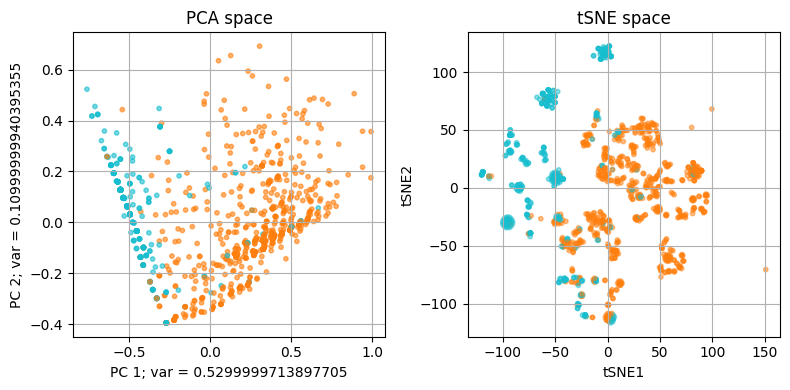

In [11]:
plt.figure(figsize=(8, 4))
X_top_feat = np.array([X_train_transposed[i] for i in sorted_cog_idx_by_mi[:N]])

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 5 
pca_run_and_plot(X_top_feat.T, n_compon, y_label_train.cpu(), category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_top_feat.T, 10, 50, RANDOM_SEED, y_label_train.cpu(),colors);

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tse_top{N}_mi_feat.pdf", format="pdf")
plt.show()


In [12]:
feat_step = 50
feat_removal = False
cv_accur_arr, test_accur_arr, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_mi, feat_step, DEVICE, feat_removal)       

In [13]:
feat_removal = True
cv_accur_arr_rem, test_accur_arr_rem, num_feat_rem = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_mi, feat_step, DEVICE, feat_removal)       

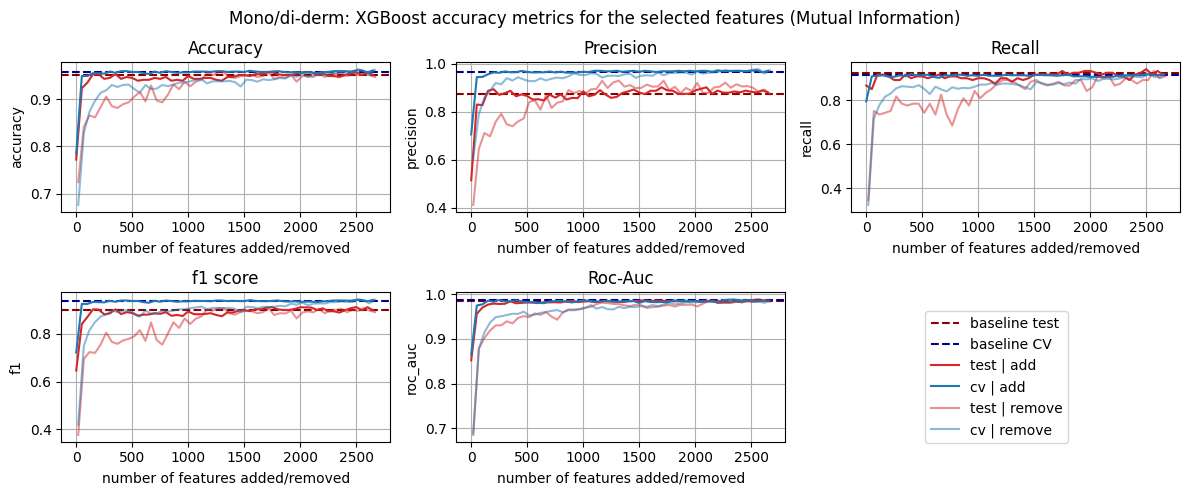

In [14]:
fig = plt.figure(figsize=(12, 5))
tot_num_feat = X_val_train.cpu().shape[1]
plt.subplot(2, 3, 1)
metric = 'accuracy'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, tot_num_feat)
plt.title("Accuracy")
plt.grid()

plt.subplot(2, 3, 2)
metric = 'precision'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, tot_num_feat)
plt.title("Precision")
plt.grid()

plt.subplot(2, 3, 3)
metric = 'recall'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, tot_num_feat)
plt.title("Recall")
plt.grid()

plt.subplot(2, 3, 4)
metric = 'f1'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, tot_num_feat)
plt.title("f1 score")
plt.grid()

plt.subplot(2, 3, 5)
metric = 'roc_auc'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, tot_num_feat)
plt.title("Roc-Auc")
plt.grid()

plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave top 5% of figure for suptitle
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1))  # near bottom-right of full figure

plt.suptitle("Mono/di-derm: XGBoost accuracy metrics for the selected features (Mutual Information)")
plt.savefig(f"{OUTPUT_DIRECTORY}/accuracy_mi_feat.pdf", format="pdf")

#### 3.2 Feature selection with Random Forest

In [15]:
from feature_selection.feature_selection_utils import random_forest_features
sorted_cog_idx_by_rand_forest, sorted_importances, sorted_names = random_forest_features(X_val_train.cpu(), y_label_train.cpu(), X_column_names)

Original feature count: 2670, Selected feature count: 396


In [16]:
# Select the top N features
N = 10
top_N_indices = sorted_cog_idx_by_rand_forest[:N]
top_N_importances = sorted_importances[:N]
top_N_names_by_rand_forest = sorted_names[:N]
top_feat_rand_forest_counts = [X_train_transposed[i] for i in sorted_cog_idx_by_rand_forest[:N]]
print(f"Top {N} COGs:", top_N_names_by_rand_forest)

Top 10 COGs: ['COG1284', 'COG0826', 'COG0321', 'COG0045', 'COG1179', 'COG0074', 'COG1328', 'COG1592', 'COG4509', 'COG0843']


In [22]:
X_top_feat = np.array([X_train_transposed[i] for i in sorted_cog_idx_by_rand_forest[:N]])

Data after PCA reduction: (5166, 5)
Shape of the projected data = (5166, 2)


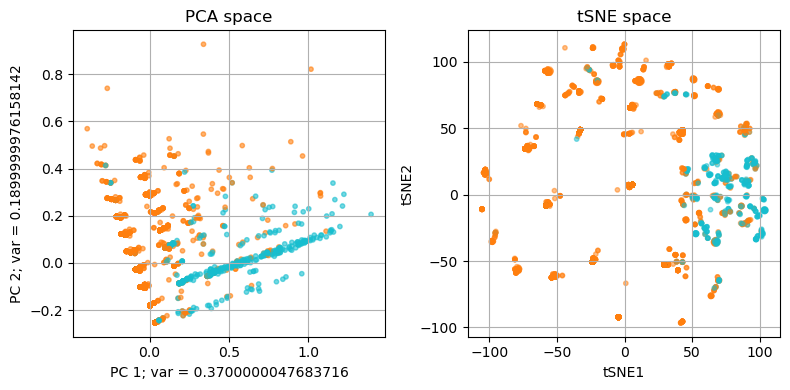

In [25]:
plt.figure(figsize=(8, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 5
pca_run_and_plot(X_top_feat.T, n_compon, y_label_train.cpu(), category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_top_feat.T, 10, 10, RANDOM_SEED, y_label_train.cpu(),colors);

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tse_top{N}_randfor_feat.pdf", format="pdf")
plt.show()

In [26]:
from sklearn.preprocessing import MaxAbsScaler

X_val_train, X_val_test = X_val_train.cpu(), X_val_test.cpu()
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_val_train)
X_val_test_scaled = scaler.fit_transform(X_val_test)

feat_step = 50
feat_removal = False
cv_accur_arr, test_accur_arr, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_rand_forest, feat_step, DEVICE, feat_removal)       

In [27]:
feat_removal = True
cv_accur_arr_rem, test_accur_arr_rem, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_rand_forest, feat_step, DEVICE, feat_removal)       

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(0.5, 0.98, 'Mono/di-derm: XGBoost accuracy metrics for the selected features (Random Forest)')

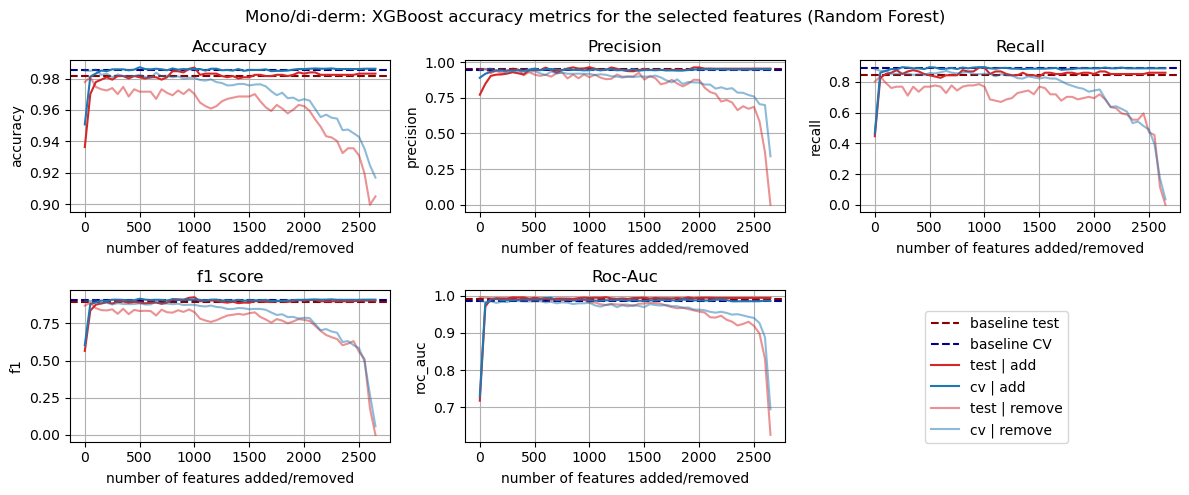

In [28]:
fig = plt.figure(figsize=(12, 5))
plt.subplot(2, 3, 1)
metric = 'accuracy'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, tot_num_feat)
plt.title("Accuracy")
plt.grid()

plt.subplot(2, 3, 2)
metric = 'precision'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, tot_num_feat)
plt.title("Precision")
plt.grid()

plt.subplot(2, 3, 3)
metric = 'recall'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, tot_num_feat)
plt.title("Recall")
plt.grid()

plt.subplot(2, 3, 4)
metric = 'f1'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_fea, tot_num_featt)
plt.title("f1 score")
plt.grid()

plt.subplot(2, 3, 5)
metric = 'roc_auc'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, tot_num_feat)
plt.title("Roc-Auc")
plt.grid()

plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave top 5% of figure for suptitle
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1))  # near bottom-right of full figure

plt.suptitle("Eco/host: XGBoost accuracy metrics for the selected features (Random Forest)")
plt.savefig(f"{OUTPUT_DIRECTORY}/accuracy_randfor_feat.pdf", format="pdf")

#### 3.3 Feature selection with SHAP values

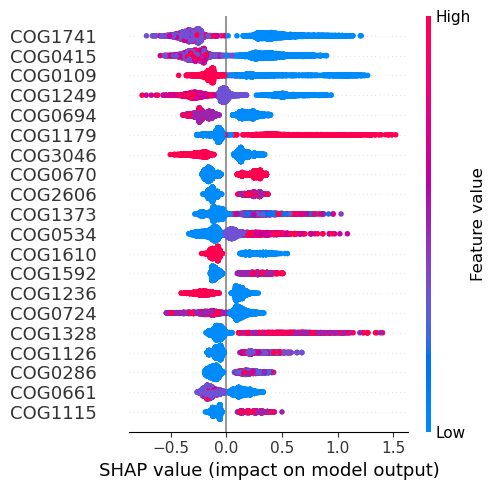

In [29]:
from feature_selection.feature_selection_utils import shap_features

device = 'cpu'
sorted_cog_idx_by_shap, sorted_shap, sorted_names = shap_features(X_val_train.cpu(), y_label_train.cpu(), X_column_names, device) 

In [30]:
# Select the top N features
N = 10
top_N_indices = sorted_cog_idx_by_shap[:N]
top_N_mi = sorted_shap[:N]
top_N_names_by_shap = sorted_names[:N]
top_feat_shap_counts = [X_train_transposed[i] for i in sorted_cog_idx_by_shap[:N]]

print(f"Top {N} COGs:", top_N_names_by_shap)

Top 10 COGs: ['COG1741', 'COG0415', 'COG0109', 'COG1249', 'COG0694', 'COG1179', 'COG3046', 'COG0670', 'COG2606', 'COG1373']


Data after PCA reduction: (5166, 5)
Shape of the projected data = (5166, 2)


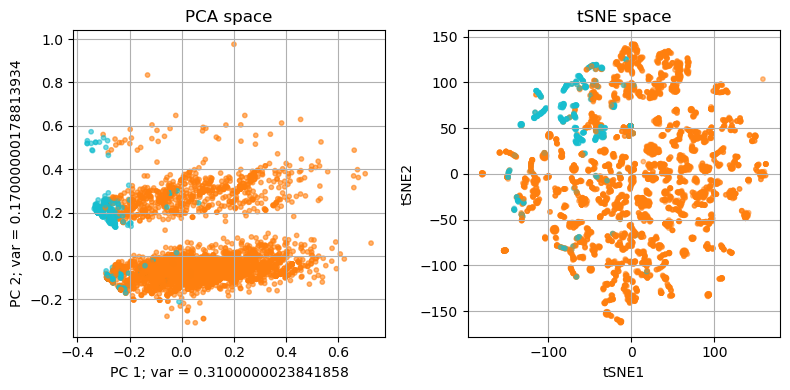

In [31]:
plt.figure(figsize=(8, 4))
X_top_feat = np.array([X_train_transposed[i] for i in sorted_cog_idx_by_shap[:N]])

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 5 
pca_run_and_plot(X_top_feat.T, n_compon, y_label_train.cpu(), category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_top_feat.T, 10, 50, RANDOM_SEED, y_label_train.cpu(),colors);

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tse_top{N}_shap_feat.pdf", format="pdf")
plt.show()

In [32]:
from sklearn.preprocessing import MaxAbsScaler

feat_step = 50
feat_removal = False
cv_accur_arr, test_accur_arr, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_shap, feat_step, DEVICE, feat_removal)       

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_

In [33]:
feat_removal = True
cv_accur_arr_rem, test_accur_arr_rem, num_feat_rem = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_shap, feat_step, DEVICE, feat_removal)       

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(0.5, 0.98, 'Mono/di-derm: XGBoost accuracy metrics for the selected features (SHAP values)')

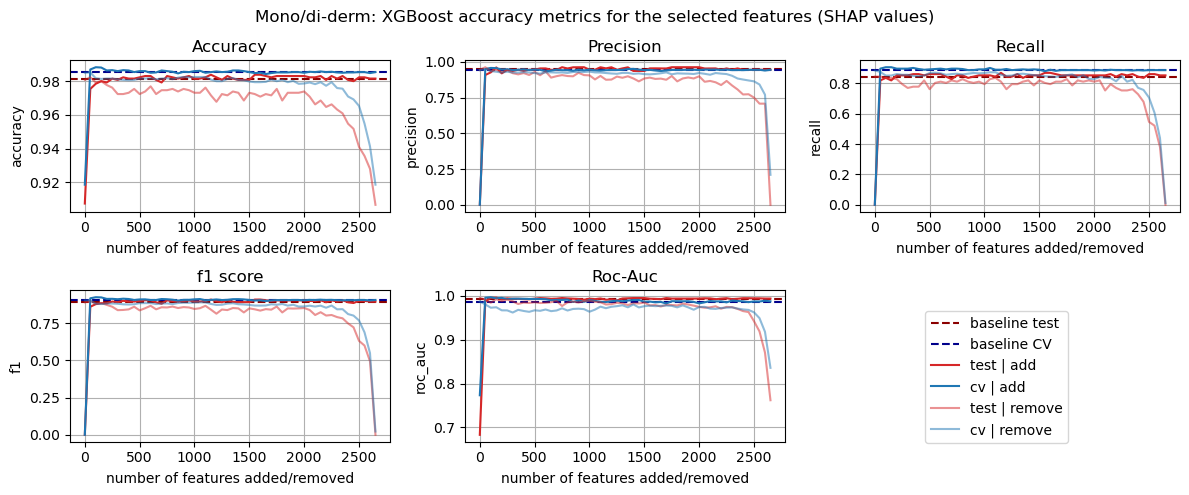

In [34]:
fig = plt.figure(figsize=(12, 5))
plt.subplot(2, 3, 1)
metric = 'accuracy'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, tot_num_feat)
plt.title("Accuracy")
plt.grid()

plt.subplot(2, 3, 2)
metric = 'precision'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_fea, tot_num_featt)
plt.title("Precision")
plt.grid()

plt.subplot(2, 3, 3)
metric = 'recall'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, tot_num_feat)
plt.title("Recall")
plt.grid()

plt.subplot(2, 3, 4)
metric = 'f1'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, tot_num_feat)
plt.title("f1 score")
plt.grid()

plt.subplot(2, 3, 5)
metric = 'roc_auc'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, tot_num_feat)
plt.title("Roc-Auc")
plt.grid()

plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave top 5% of figure for suptitle
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1))  # near bottom-right of full figure

plt.suptitle("Eco/host: XGBoost accuracy metrics for the selected features (SHAP values)")
plt.savefig(f"{OUTPUT_DIRECTORY}/accuracy_shap_feat.pdf", format="pdf")

#### 4. Feature comparison

In [35]:
import pandas as pd

# Define the data for the columns
data = {
    'MI': top_N_names_by_mi,
    'RandomForest': top_N_names_by_rand_forest,
    'SHAP': top_N_names_by_shap
}

# Create DataFrame with specified column names
df = pd.DataFrame(data)

# Print the DataFrame
display(df)

,MI,RandomForest,SHAP
0,COG0826,COG4509,COG1741
1,COG4509,COG1284,COG0415
2,COG0109,COG1854,COG0109
3,COG1854,COG1882,COG1249
4,COG1328,COG1179,COG0694
5,COG1592,COG0508,COG1179
6,COG0074,COG2868,COG3046
7,COG0843,COG3887,COG0670
8,COG1971,COG3641,COG2606
9,COG1179,COG0320,COG1373


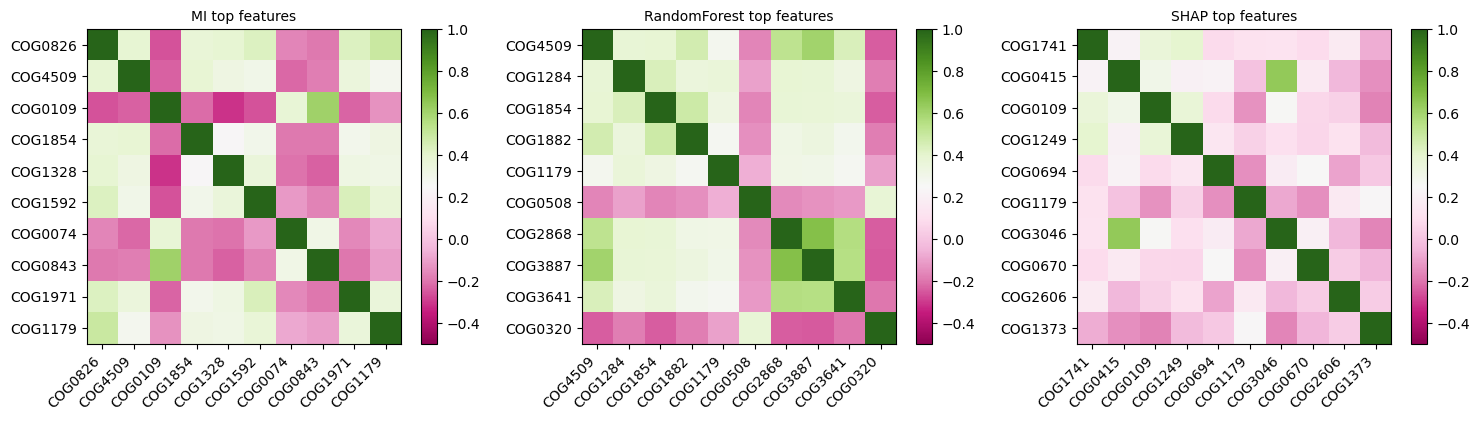

In [36]:
plt.figure(figsize=(15, 4))

vmin, vmax = -0.5, 1 #-0.6

# Correlation matrix for MI top features
plt.subplot(1, 3, 1) 
correlation_matrix = np.corrcoef(top_feat_mi_counts)
plt.imshow(correlation_matrix, vmin=vmin, vmax=vmax, cmap="PiYG")
plt.title("MI top features", fontsize=10)
plt.xticks(ticks=np.arange(len(top_N_names_by_mi)), labels=top_N_names_by_mi, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(top_N_names_by_mi)), labels=top_N_names_by_mi)
plt.colorbar()

# Correlation matrix for RandomForest top features
plt.subplot(1, 3, 2) 
correlation_matrix = np.corrcoef(top_feat_rand_forest_counts) 
plt.imshow(correlation_matrix, vmin=vmin, vmax=vmax, cmap="PiYG")
plt.title("RandomForest top features", fontsize=10)
plt.xticks(ticks=np.arange(len(top_N_names_by_rand_forest)), labels=top_N_names_by_rand_forest, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(top_N_names_by_rand_forest)), labels=top_N_names_by_rand_forest)
plt.colorbar()

# Correlation matrix for SHAP top features
plt.subplot(1, 3, 3) 
correlation_matrix = np.corrcoef(top_feat_shap_counts) 
plt.imshow(correlation_matrix, vmin=vmin, vmax=vmax, cmap="PiYG")
plt.title("SHAP top features", fontsize=10)
plt.xticks(ticks=np.arange(len(top_N_names_by_shap)), labels=top_N_names_by_shap, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(top_N_names_by_shap)), labels=top_N_names_by_shap)
plt.colorbar()

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/correlat_matr_top{N}_feat.pdf", format="pdf")
plt.show()
